In [37]:
# Upload Kaggle json

!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Kaggle/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json
i = False
!kaggle competitions download -c fake-news -p dataset
# !kaggle datasets download -c someone/some-data -p dataset

{"username":"nabanitaroy","key":"ca9305e9d6b82e6852331c98234e9ef7"}Warning: Looks like you're using an outdated API Version, please consider updating (server 1.5.9 / client 1.5.4)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
submit.csv: Skipping, found more recently modified local copy (use --force to force download)


In [38]:
!unzip /content/dataset/train.csv.zip

Archive:  /content/dataset/train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [39]:
!unzip /content/dataset/test.csv.zip

Archive:  /content/dataset/test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [114]:
from time import time
import pandas as pd
import numpy as np
import re
import sys
import csv
csv.field_size_limit(sys.maxsize)

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10,10]
import seaborn as sns
sns.set_theme(style="darkgrid")

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize

import itertools
import datetime

import pprint
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
train_df = pd.read_csv('/content/train.csv', header=0)
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [42]:
train_df.shape

(20800, 5)

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


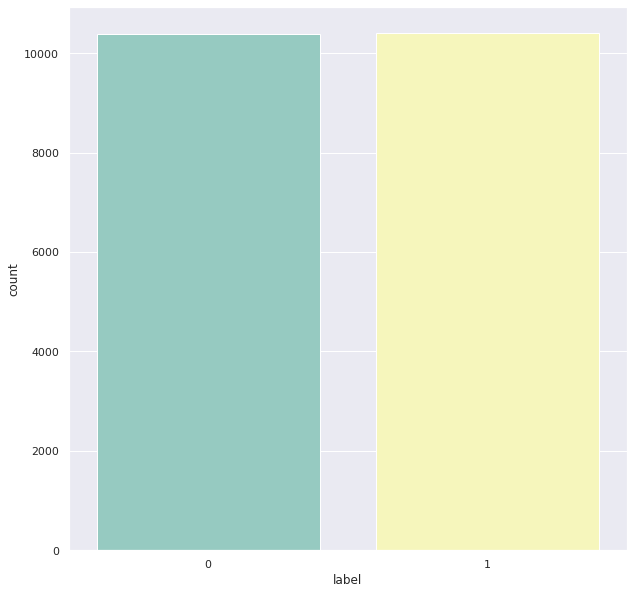

In [44]:
sns.countplot(x='label', data=train_df, palette='Set3')

Slightly imabalnced with a ratio of ~ 4:5

In [45]:
test_df = pd.read_csv('/content/test.csv', header=0)
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [46]:
test_df.shape

(5200, 4)

In [47]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 162.6+ KB


## Drop all instances which have atleast one column missing

In [48]:
train_df.dropna(axis=0, how='any',inplace=True)
test_df.dropna(axis=0, how='any',inplace=True)

In [49]:
train_df.shape, test_df.shape

((18285, 5), (4575, 4))

In [50]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18285 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18285 non-null  int64 
 1   title   18285 non-null  object
 2   author  18285 non-null  object
 3   text    18285 non-null  object
 4   label   18285 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 857.1+ KB


In [51]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4575 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4575 non-null   int64 
 1   title   4575 non-null   object
 2   author  4575 non-null   object
 3   text    4575 non-null   object
dtypes: int64(1), object(3)
memory usage: 178.7+ KB


## Check length of Text

In [52]:
train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))

In [53]:
train_df.head()

,id,title,author,text,label,raw_text_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938


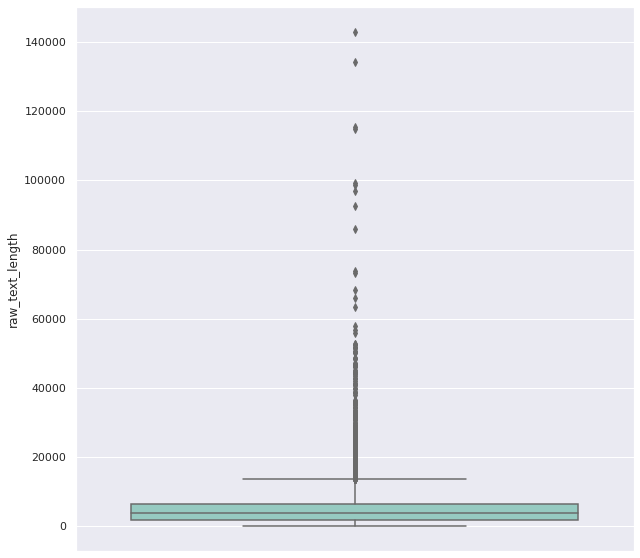

In [54]:
sns.boxplot(y='raw_text_length', data=train_df, palette="Set3")

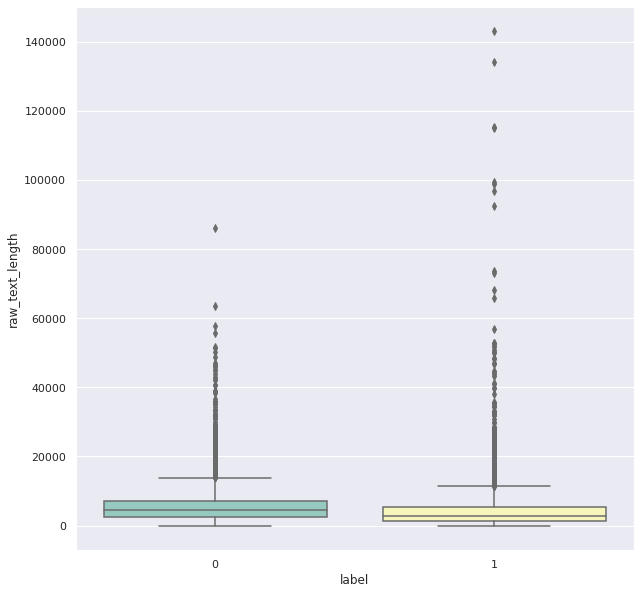

In [55]:
sns.boxplot(y='raw_text_length', x='label', data=train_df, palette="Set3")

In [56]:
len(train_df['author'].unique())

3838

In [57]:
gen_news_authors = set(list(train_df[train_df['label']==0]['author'].unique()))
fake_news_authors = set(list(train_df[train_df['label']==1]['author'].unique()))

In [58]:
overlapped_authors = gen_news_authors.intersection(fake_news_authors)

In [59]:
len(gen_news_authors), len(fake_news_authors), len(overlapped_authors)

(2225, 1618, 5)

## Text Cleaning

1. Convert to lower-case
2. Remove special characters
3. Remove single letters
4. Expand contractions
5. Remove Stopwords

In [60]:
!pip install contractions

In [61]:
import contractions
print(contractions.fix("i've"))
print(contractions.fix("he's"))

I have
he is


In [62]:
# re.sub(r'[^\w\d\s\']+', '', 'I have $500 and I love that! I said "WHAT" eğitmeye')
re.sub(r'[^a-zA-Z\d\s\']+', '', 'I have $500 and I love that! I said "WHAT" eğitmeye')

'I have 500 and I love that I said WHAT eitmeye'

In [63]:
len('z'), 'Z'.lower()

(1, 'z')

In [64]:
def preprocess_text(x):
  cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', x)
  word_list = []
  for each_word in cleaned_text.split(' '):
    try:
      word_list.append(contractions.fix(each_word).lower())
    except: 
      print(x)
  return " ".join(word_list)

## Got Error because of some sort of Turkish/Slavic language
ABÇin ilişkilerinde ABD ve NATOnun etkisi yazan Manlio Dinucci Uluslararası bir forumda konuşan İtalyan coğrafyacı Manlio Dinucci ABDnin tüm dünyaya egemen olabilmek için sahip olduğu silahların analizini bireşimleştirdi Suriye Rusya ve Çinin bugün elde silah herkesin açıkça kabul ettiği bu üstünlüğü dünyanın bu tek kutuplu örgütlenişi tartışılır hale getirmesinden dolayı bu makale daha da önem kazanmaktadır


In [65]:
text_cols = ['text', 'title', 'author']

In [66]:
%%time
for col in text_cols:
  print("Processing column: {}".format(col))
  train_df[col] = train_df[col].apply(lambda x: preprocess_text(x))
  test_df[col] = test_df[col].apply(lambda x: preprocess_text(x)) 

Processing column: text
Processing column: title
Processing column: author
CPU times: user 54.2 s, sys: 88.2 ms, total: 54.3 s
Wall time: 54.4 s


In [67]:
%%time
for col in text_cols:
  print("Processing column: {}".format(col))
  train_df[col] = train_df[col].apply(word_tokenize)
  test_df[col] = test_df[col].apply(word_tokenize)

Processing column: text
Processing column: title
Processing column: author
CPU times: user 1min 17s, sys: 1.03 s, total: 1min 18s
Wall time: 1min 18s


In [71]:
%%time
for col in text_cols:
  print("Processing column: {}".format(col))
  train_df[col] = train_df[col].apply(lambda x: [each_word for each_word in x if each_word not in stopwords])
  test_df[col] = test_df[col].apply(lambda x: [each_word for each_word in x if each_word not in stopwords])

Processing column: text
Processing column: title
Processing column: author
CPU times: user 30.6 s, sys: 57.5 ms, total: 30.6 s
Wall time: 30.7 s


In [73]:
train_df.head()

,id,title,author,text,label,raw_text_length
0,0,"[house, dem, aide, even, see, comeys, letter, ...","[darrell, lucus]","[house, dem, aide, even, see, comeys, letter, ...",1,4930
1,1,"[flynn, hillary, clinton, big, woman, campus, ...","[daniel, j, flynn]","[ever, get, feeling, life, circles, roundabout...",0,4160
2,2,"[truth, might, get, fired]",[consortiumnewscom],"[truth, might, get, fired, october, 29, 2016, ...",1,7692
3,3,"[15, civilians, killed, single, us, airstrike,...","[jessica, purkiss]","[videos, 15, civilians, killed, single, us, ai...",1,3237
4,4,"[iranian, woman, jailed, fictional, unpublishe...","[howard, portnoy]","[print, iranian, woman, sentenced, six, years,...",1,938


In [74]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

In [81]:
sentence = ["an apple a day keeps the doctor away"]
v = CountVectorizer(ngram_range=(1,2))

In [84]:
print(v.fit(sentence))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


In [87]:
v.get_feature_names()

['an',
 'an apple',
 'apple',
 'apple day',
 'away',
 'day',
 'day keeps',
 'doctor',
 'doctor away',
 'keeps',
 'keeps the',
 'the',
 'the doctor']

In [93]:
v.transform(sentence)

<1x13 sparse matrix of type '<class 'numpy.int64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [89]:
v.vocabulary_

{'an': 0,
 'an apple': 1,
 'apple': 2,
 'apple day': 3,
 'away': 4,
 'day': 5,
 'day keeps': 6,
 'doctor': 7,
 'doctor away': 8,
 'keeps': 9,
 'keeps the': 10,
 'the': 11,
 'the doctor': 12}

In [94]:
train_df.head()

,id,title,author,text,label,raw_text_length
0,0,"[house, dem, aide, even, see, comeys, letter, ...","[darrell, lucus]","[house, dem, aide, even, see, comeys, letter, ...",1,4930
1,1,"[flynn, hillary, clinton, big, woman, campus, ...","[daniel, j, flynn]","[ever, get, feeling, life, circles, roundabout...",0,4160
2,2,"[truth, might, get, fired]",[consortiumnewscom],"[truth, might, get, fired, october, 29, 2016, ...",1,7692
3,3,"[15, civilians, killed, single, us, airstrike,...","[jessica, purkiss]","[videos, 15, civilians, killed, single, us, ai...",1,3237
4,4,"[iranian, woman, jailed, fictional, unpublishe...","[howard, portnoy]","[print, iranian, woman, sentenced, six, years,...",1,938


In [95]:
train_df['text_joined'] = train_df['text'].apply(lambda x: " ".join(x))
test_df['text_joined'] = test_df['text'].apply(lambda x: " ".join(x))

In [96]:
train_df.head()

,id,title,author,text,label,raw_text_length,text_joined
0,0,"[house, dem, aide, even, see, comeys, letter, ...","[darrell, lucus]","[house, dem, aide, even, see, comeys, letter, ...",1,4930,house dem aide even see comeys letter jason ch...
1,1,"[flynn, hillary, clinton, big, woman, campus, ...","[daniel, j, flynn]","[ever, get, feeling, life, circles, roundabout...",0,4160,ever get feeling life circles roundabout rathe...
2,2,"[truth, might, get, fired]",[consortiumnewscom],"[truth, might, get, fired, october, 29, 2016, ...",1,7692,truth might get fired october 29 2016 tension ...
3,3,"[15, civilians, killed, single, us, airstrike,...","[jessica, purkiss]","[videos, 15, civilians, killed, single, us, ai...",1,3237,videos 15 civilians killed single us airstrike...
4,4,"[iranian, woman, jailed, fictional, unpublishe...","[howard, portnoy]","[print, iranian, woman, sentenced, six, years,...",1,938,print iranian woman sentenced six years prison...


In [105]:
tf_idf_transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

# fit train data to the count vectorizer
count_vect_train = count_vectorizer.fit_transform(train_df['text_joined'].values)

#fit the ngrams count to the tfidf transformers
tf_idf_train = tf_idf_transformer.fit_transform(count_vect_train)

In [106]:
count_vect_train

<18285x4457643 sparse matrix of type '<class 'numpy.int64'>'
	with 12940845 stored elements in Compressed Sparse Row format>

In [107]:
tf_idf_train

<18285x4457643 sparse matrix of type '<class 'numpy.float64'>'
	with 12940845 stored elements in Compressed Sparse Row format>

In [108]:
target = train_df['label'].values

In [109]:
from sklearn.model_selection import train_test_split

#  If train-test size is not initialized, test_size will be set to 0.25 and train_set = 1-test_size

X_train, X_test, y_train, y_test = train_test_split(tf_idf_train, target, random_state=0)

In [117]:
df_perf_metrics = pd.DataFrame(columns  =['Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision', 'Recall', 'f1_score'])

In [112]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(C=1e5)
log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)

df_perf_metrics = [
    "Logistic Regression",
    log_reg_model.score(X_train, y_train))),
    log_reg_model.score(X_test, y_test))),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    f1_score(y_test, y_pred)
]

Accuracy of Logreg classifier on training set: 1.00
Accuracy of Logreg classifier on test set: 0.97


In [113]:
RandomFC= RandomForestClassifier(n_estimators=5)
RandomFC.fit(X_train, y_train)

print('Accuracy of randomforest classifier on training set: {:.2f}'.format(RandomFC.score(X_train, y_train)))

print('Accuracy of randomforest classifier on test set: {:.2f}'.format(RandomFC.score(X_test, y_test)))

Accuracy of randomforest classifier on training set: 0.98
Accuracy of randomforest classifier on test set: 0.82


In [110]:
Extr = ExtraTreesClassifier(n_estimators=5,n_jobs=4)
Extr.fit(X_train, y_train)

print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(Extr.score(X_train, y_train)))

print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(Extr.score(X_test, y_test)))

Accuracy of ExtraTrees classifier on train set: 1.00
Accuracy of ExtraTrees classifier on test set: 0.83


In [111]:
Adab= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(X_train, y_train)

print('Accuracy of Adaboost classifier on training set: {:.2f}'.format(Adab.score(X_train, y_train)))

print('Accuracy of Adaboost classifier on test set: {:.2f}'.format(Adab.score(X_test, y_test)))

Accuracy of Adaboost classifier on training set: 0.90
Accuracy of Adaboost classifier on test set: 0.90
